# Homework 01 for Taxi Duration Prediction - Linear Regression Model

## Display Python Version

In [1]:
!python -V

Python 3.12.1


## Import Libraries

In [ ]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import pickle  # For saving and loading serialized objects
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting graphs

# Import classes and functions from scikit-learn
from sklearn.feature_extraction import DictVectorizer  # For converting dictionaries to feature matrices
from sklearn.linear_model import LinearRegression  # For linear regression modeling
from sklearn.linear_model import Lasso  # For Lasso regression (L1 regularization)
from sklearn.linear_model import Ridge  # For Ridge regression (L2 regularization)

# Import metric for evaluating model performance
from sklearn.metrics import root_mean_squared_error  # For calculating RMSE

## Install pyarrow

In [6]:
!pip install pyarrow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Read Yellow Taxi Trip Data for January 2023

In [ ]:
# Read the parquet file into a pandas DataFrame
# The file contains taxi trip data for January 2023
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

### Number of Columns in the Jan 2023 yellow trip data

In [8]:
len(df.columns)

19

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### Calculate Duration in Minutes

In [10]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

### Standard Deviation for Duration

In [13]:
print(f"Standard Deviation of Duration: {df['duration'].std()}")

Standard Deviation of Duration: 42.59435124195458


### Number of Records in the data

In [14]:
df_original_count = df.shape[0]
print(f"Original Count: {df_original_count}")

Original Count: 3066766


### Remove Outliers and Check the Percentage of data that remains

In [15]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
print(f"Filtered Count Percentage: {df.shape[0] / df_original_count * 100:.2f}%")

Filtered Count Percentage: 98.12%


### Define the Categorical and Numerical Columns

In [16]:
# Define the categorical and numerical columns to be used
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# Convert the categorical columns to string type
df[categorical] = df[categorical].astype(str)

### Convert the Selected Columns into a List of Dictionaries

In [17]:
# Convert the selected columns (categorical and numerical) of the dataframe into a list of dictionaries
# Each dictionary represents a row in the dataframe with the specified columns
train_dicts = df[categorical + numerical].to_dict(orient='records')

### Initialize a DictVectorizer and create X_train set

In [18]:
# Initialize a DictVectorizer instance to convert dictionaries to a feature matrix
dv = DictVectorizer()

# Fit the DictVectorizer on the training data (list of dictionaries) and transform it into a sparse matrix
X_train = dv.fit_transform(train_dicts)

### Display the shape of X_train

In [22]:
# The `X_train` variable is a Compressed Sparse Row (CSR) matrix.
# It is a sparse representation of the feature matrix created using the DictVectorizer.
# The matrix has 3,009,173 rows (one for each training sample) and 516 columns (one for each feature).
# It contains 9,027,519 non-zero elements, which represent the encoded feature values.
X_train.shape

(3009173, 516)

### Train a Linear Regression Model and Evaluate on Validation Set

In [23]:
# Define the target variable for prediction
target = 'duration'

# Extract the target variable values from the dataframe as a numpy array
y_train = df[target].values

# Initialize a Linear Regression model
lr = LinearRegression()

# Train the Linear Regression model using the training data (X_train) and target variable (y_train)
lr.fit(X_train, y_train)

# Predict the target variable using the trained model on the training data
y_pred = lr.predict(X_train)

# Calculate and return the Root Mean Squared Error (RMSE) between the actual and predicted values
print(f"RMSE: {root_mean_squared_error(y_train, y_pred):.2f}")

RMSE: 7.66


In [24]:
import warnings
warnings.filterwarnings("ignore")

### Plot the kdeplot for prediction and training set

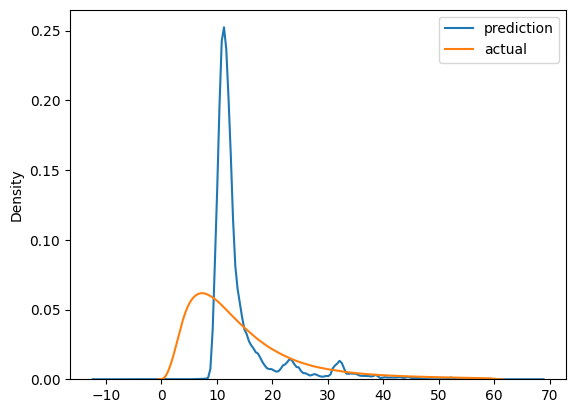

In [25]:
sns.kdeplot(y_pred, label='prediction')
sns.kdeplot(y_train, label='actual')
plt.legend()
plt.show()

### Function: `read_dataframe`

This function reads a dataset from a file (either `.csv` or `.parquet`), processes it, and returns a cleaned pandas DataFrame. The key steps performed by the function are:

In [26]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

### Read Training and Validation Datasets

In [27]:
df_train = read_dataframe('../data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2023-02.parquet')

In [28]:
len(df_train), len(df_val)

(3009173, 2855951)

In [ ]:
# Create a new column 'PU_DO' in the training dataset by concatenating 'PULocationID' and 'DOLocationID' with an underscore
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']

# Create a new column 'PU_DO' in the validation dataset by concatenating 'PULocationID' and 'DOLocationID' with an underscore
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [30]:
# Update the categorical and numerical columns to be used
categorical = ['PU_DO']  # Use the combined pickup and drop-off location column
numerical = ['trip_distance']  # Use trip distance as the numerical feature

# Initialize a DictVectorizer instance to convert dictionaries to a feature matrix
dv = DictVectorizer()

# Convert the training dataset into a list of dictionaries using the selected columns
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

# Fit the DictVectorizer on the training data and transform it into a sparse matrix
X_train = dv.fit_transform(train_dicts)

# Convert the validation dataset into a list of dictionaries using the selected columns
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

# Transform the validation data into a sparse matrix using the already fitted DictVectorizer
X_val = dv.transform(val_dicts)

In [31]:
# Define the target variable for prediction
target = 'duration'

# Extract the target variable values from the training dataset as a numpy array
y_train = df_train[target].values

# Extract the target variable values from the validation dataset as a numpy array
y_val = df_val[target].values

### Train a Linear Regression Model

In [32]:
# Initialize a Linear Regression model
lr = LinearRegression()

# Train the Linear Regression model using the training data (X_train) and target variable (y_train)
lr.fit(X_train, y_train)

# Predict the target variable using the trained model on the validation data
y_pred = lr.predict(X_val)

# Calculate and return the Root Mean Squared Error (RMSE) between the actual and predicted values
print(f"RMSE for Validation Set: {root_mean_squared_error(y_val, y_pred):.2f}")

RMSE for Validation Set: 5.26


### Save the created model

In [33]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Redo the same model using Lasso

In [34]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print(f"RMSE for Validation Set with Lasso: {root_mean_squared_error(y_val, y_pred):.2f}")

RMSE for Validation Set with Lasso: 9.40
